# Golden Age: A transnational approach

Influential genres of art and literature from the ancient Greek and the Roman Empire to the Renaissance and the rise of Modernism have made their mark on history. Periods from early 16th century to the late 17th century have been considered the high point in literature and art in several countries.

In this sense, the Dutch Golden Age is a period in the history of Netherlands from 1575 to 1675 in which Dutch science and art were among the most acclaimed in the world. Similarly, the Spanish Golden Age is a period of flourishing in arts and literature in Spain during the 16th and 17th centuries.

GLAM institutions have made a great effort in order to digitise and make openly available in different forms the literature and art produce in this period. In addition, For instance, the Rijksmuseum and the Metropolitan Museum of Art offers different ways of accessing the collection data, such as downloads and APIs.\footnote{https://www.rijksmuseum.nl/en/data} Several corpora have been published including text using standard and interoperable formats.\cite{DBLP:conf/datech/RomeroEN17} Wikidata have been collaborativelly edited by volunteers and enriched by repositories of all around the world. Other approaches are based on the use of Linked Open Data to track and trace processes of canonization in early modern Dutch literature publishing enriched LOD datasets as a result.\cite{nijboer_harm_2020_3875652}

This transnational dataset is based in several repositories that are available in different platforms, using different formats and including different types of materials. Table \ref{art} presents an overview of the sources used including the main features of each of them.


add table!!!

|Institution|URL|Fearures|
|---|---|---|
|British National Bibliography| https://bnb.data.bl.uk  | P5361  |
|Biblioteca Nacional de España   | http://datos.bne.es     | P950  | 
|Bibliothèque nationale du France   | https://data.bnf.fr  | P268  | 
|National Library of Greece | https://data.nlg.gr | P3348|
|National Library of Korea | http://lod.nl.go.kr | P5034|
|National Library of Netherlands | https://data.bibliotheken.nl | P1006|


If we visit the entity of [Francis Bacon](https://www.wikidata.org/wiki/Q37388) in Wikidata we will see the British National Bibliography property (see the identifiers section):

<img src="images/francis-bacon-wikidata.png" width="60%">

We can create SPARQL queries using the properties of the national libraries in order to filter the results using the [Wikidata Query Service](https://w.wiki/ja8):

```
SELECT *
WHERE {?item wdt:P5361 ?idBNB}
LIMIT 100
```

## Setting up things

This part is essential to declare all the Python packages that we are going to use through the notebook. Note that packages can be stated in different cells but in order to provide a clean code they should be grouped in one cell.

In [2]:
import requests as r
import pandas as pd
import json
import matplotlib.pyplot as plt
from pandas.io.json import json_normalize  
from datapackage import Package
from SPARQLWrapper import SPARQLWrapper, JSON
import networkx as nx
from matplotlib.pyplot import figure

## Let's query the repository by asking the authors linked in Wikidata
We will use the [SPARQL endpoint](https://bnb.data.bl.uk/flint-sparql) to create the query and configure the request to retrieve json as a result. 

The SPARQL query includes several UNION instructions to query each library by means of its property. The authors are filtered by birth date. The OPTIONAL instruction is used to include the value in case it exists in Wikidata.

The instruction Bind in SPARQL allows to bind values. In this case we are using [wd:Q2352880]() (Spanish Golden Age) and [wd:Q530936]() (Dutch Golden Age).

*Note: The execution of this query may take a while. The result is already provided in this [project](libraries-data.json) so you can pass to the next step.*

In [16]:
sparql = SPARQLWrapper("https://query.wikidata.org/sparql")

sparql.setQuery("""
SELECT ?item (SAMPLE(?idviaf) as ?viaf) ?itemLabel ?periodLabel
(GROUP_CONCAT(DISTINCT ?educated;separator="|") as ?educatedAt) 
(GROUP_CONCAT(DISTINCT ?influenced;separator="|") as ?influencedBy) 
(GROUP_CONCAT(DISTINCT ?genre;separator="|") as ?genres)
(GROUP_CONCAT(DISTINCT ?languageSpoken;separator="|") as ?languagesSpoken)
WHERE 
{
  {
    VALUES ?period {wd:Q2352880 wd:Q530936} 
    ?item wdt:P135 ?period.
    ?item wdt:P31 wd:Q5.
    ?item wdt:P214 ?idviaf.
    OPTIONAL {?item wdt:P737 ?influenced.}
    OPTIONAL {?item wdt:P136 ?genre.}
    OPTIONAL {?item wdt:P69 ?educated.}
    OPTIONAL {?item wdt:P1412 ?languageSpoken.}
  }
  SERVICE wikibase:label { bd:serviceParam wikibase:language "[AUTO_LANGUAGE],en".}
}
GROUP BY ?item ?itemLabel ?viaf ?periodLabel""")
sparql.setReturnFormat(JSON)
results = sparql.query().convert()

## Save as a JSON file

The result can be stored as a JSON file.

**Note: the file is already in the Github repository since the query above requires a long time to be executed.**

In [17]:
with open('golden-age.json', 'w') as json_file:
    json.dump(results, json_file)

## Exploring the data

Now we will explore the data. First, we open the JSON file and load the data in a Pandas dataframe. A dataframe in Pandas is a data structure with columns of potentially different types. You can think of it like a spreadsheet or SQL table.

In [18]:
# Load the JSON file from disk
# This puts the data in a Pandas DataFrame
with open('golden-age.json') as f:
    data = json.load(f)

ga_df = pd.io.json.json_normalize(data['results']['bindings'])    
ga_df.head()

/home/gustavo/.local/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  


,item.type,item.value,itemLabel.xml:lang,itemLabel.type,itemLabel.value,viaf.type,viaf.value,periodLabel.xml:lang,periodLabel.type,periodLabel.value,educatedAt.type,educatedAt.value,influencedBy.type,influencedBy.value,genres.type,genres.value,languagesSpoken.type,languagesSpoken.value
0,uri,http://www.wikidata.org/entity/Q12023294,en,literal,Jan van Gool,literal,57416265,en,literal,Dutch Golden Age painting,literal,,literal,,literal,,literal,http://www.wikidata.org/entity/Q7411
1,uri,http://www.wikidata.org/entity/Q17343011,en,literal,Jacob de Gheyn III,literal,60611905,en,literal,Dutch Golden Age painting,literal,,literal,,literal,,literal,
2,uri,http://www.wikidata.org/entity/Q2359229,en,literal,Jan Albertsz Rotius,literal,95736294,en,literal,Dutch Golden Age painting,literal,,literal,,literal,http://www.wikidata.org/entity/Q134307,literal,
3,uri,http://www.wikidata.org/entity/Q2486642,en,literal,David van der Plas,literal,22412408,en,literal,Dutch Golden Age painting,literal,,literal,,literal,http://www.wikidata.org/entity/Q134307,literal,http://www.wikidata.org/entity/Q7411
4,uri,http://www.wikidata.org/entity/Q2576955,en,literal,Jacob van Loo,literal,95460534,en,literal,Dutch Golden Age painting,literal,,literal,,literal,http://www.wikidata.org/entity/Q134307|http://...,literal,http://www.wikidata.org/entity/Q7411


### Let's see the columns

The Wikidata results are provided in JSON format. Each field are described by means of three columns: datatype, type and value. We are interested in the value column (e.g. birthdate.value).

* item: identifier of the author in Wikidata. Wikidata identifiers starts with a Q. 
* itemLabel: label of the author in Wikidata. For instance, Miguel de Cervantes.
* id: identifier in the external institution.
* birthdate 
* deathdate 
* org: this field stores the institution that is linked from Wikidata
* writtenLanguageLabel
* deathcauseLabel 
* placeofburial 
* placeofburialLabel 
* geoplaceofburial: coordinates of the place of burial of the author 
* occupationLabel: a list of occupations of the author separated by a '|'

In [19]:
ga_df.columns 

Index(['item.type', 'item.value', 'itemLabel.xml:lang', 'itemLabel.type',
       'itemLabel.value', 'viaf.type', 'viaf.value', 'periodLabel.xml:lang',
       'periodLabel.type', 'periodLabel.value', 'educatedAt.type',
       'educatedAt.value', 'influencedBy.type', 'influencedBy.value',
       'genres.type', 'genres.value', 'languagesSpoken.type',
       'languagesSpoken.value'],
      dtype='object')

In [22]:
ga_df.loc[ga_df['periodLabel.value'] == 'Dutch Golden Age painting'].head()

,item.type,item.value,itemLabel.xml:lang,itemLabel.type,itemLabel.value,viaf.type,viaf.value,periodLabel.xml:lang,periodLabel.type,periodLabel.value,educatedAt.type,educatedAt.value,influencedBy.type,influencedBy.value,genres.type,genres.value,languagesSpoken.type,languagesSpoken.value
0,uri,http://www.wikidata.org/entity/Q12023294,en,literal,Jan van Gool,literal,57416265,en,literal,Dutch Golden Age painting,literal,,literal,,literal,,literal,http://www.wikidata.org/entity/Q7411
1,uri,http://www.wikidata.org/entity/Q17343011,en,literal,Jacob de Gheyn III,literal,60611905,en,literal,Dutch Golden Age painting,literal,,literal,,literal,,literal,
2,uri,http://www.wikidata.org/entity/Q2359229,en,literal,Jan Albertsz Rotius,literal,95736294,en,literal,Dutch Golden Age painting,literal,,literal,,literal,http://www.wikidata.org/entity/Q134307,literal,
3,uri,http://www.wikidata.org/entity/Q2486642,en,literal,David van der Plas,literal,22412408,en,literal,Dutch Golden Age painting,literal,,literal,,literal,http://www.wikidata.org/entity/Q134307,literal,http://www.wikidata.org/entity/Q7411
4,uri,http://www.wikidata.org/entity/Q2576955,en,literal,Jacob van Loo,literal,95460534,en,literal,Dutch Golden Age painting,literal,,literal,,literal,http://www.wikidata.org/entity/Q134307|http://...,literal,http://www.wikidata.org/entity/Q7411


In [79]:
import rdflib
from rdflib import Graph, Literal, RDF, URIRef
# rdflib knows about some namespaces, like FOAF
from rdflib.namespace import FOAF , XSD
from rdflib import Namespace

# create a Graph
g = rdflib.Graph()

SDO = Namespace("https://schema.org/")

g.bind("schema", SDO)

# create a Graph
g = Graph()

g.namespace_manager.bind('schema', SDO, override=False)

https://schema.org/CreativeWork


In [82]:
import requests 
import json

for index, row in ga_df.loc[ga_df['periodLabel.value'] == 'Dutch Golden Age painting'].iterrows():
    print(row['itemLabel.value'])
    
    idWikidata = str(row['item.value'].replace('http://www.wikidata.org/entity/',''))
    
    person = URIRef("http://example.org/person/" + idWikidata)
    g.add((person, RDF.type, SDO.Person))
    g.add((work, RDF.type, FOAF.Person))
    g.add((person, FOAF.name, Literal(row['itemLabel.value'])))
    g.add((person, SDO.identifier, Literal(idWikidata)))
    g.add((person, SDO.sameAs, URIRef(row['item.value'])))
    g.add((person, SDO.sameAs, URIRef('https://viaf.org/viaf/' + str(row['viaf.value']))))
    
    # Making a get request 
    response = requests.get('https://www.rijksmuseum.nl/api/nl/collection?key=bfRVDJWA&involvedMaker=' + row['itemLabel.value']) 
  
    # print json content 
    #print(response.json())
    data = response.json()
    for p in data['artObjects']:
        print(p)
        
        work = URIRef("http://example.org/work/" + str(p['id']))
        
        # Add triples using store's add() method.
        g.add((work, RDF.type, SDO.CreativeWork))
        g.add((work, RDF.type, SDO.Painting))
        g.add((work, SDO.creator, person))
        
        #print(p['title'])
        g.add((work, SDO.name, Literal(p['title'], lang="nl")))
        g.add((work, SDO.name, Literal(p['longTitle'], lang="nl")))
        g.add((work, SDO.identifier, Literal(p['id'])))
        g.add((work, SDO.maintainer, URIRef('https://www.rijksmuseum.nl/')))
        g.add((work, SDO.license, URIRef('https://www.rijksmuseum.nl/en/data/policy')))
        if p['webImage'] and p['webImage']['width'] :
            print(p['webImage']['width'])
            g.add((work, SDO.width, Literal(p['webImage']['width'])))
        if p['webImage'] and p['webImage']['height'] :    
            print(p['webImage']['height'])
            g.add((work, SDO.height, Literal(p['webImage']['height'])))
        if p['webImage'] and p['webImage']['url'] :    
            print(p['webImage']['url'])
            g.add((work, SDO.image, URIRef(p['webImage']['url'])))
        for loc in p['productionPlaces']:    
            g.add((work, SDO.locationCreated, Literal(loc, lang="nl")))


print(g.serialize(format='n3').decode("utf-8"))
    
    

Jan van Gool
{'links': {'self': 'http://www.rijksmuseum.nl/api/nl/collection/SK-C-133', 'web': 'http://www.rijksmuseum.nl/nl/collectie/SK-C-133'}, 'id': 'nl-SK-C-133', 'objectNumber': 'SK-C-133', 'title': 'Arcadisch landschap met herders en vee', 'hasImage': True, 'principalOrFirstMaker': 'Jan van Gool', 'longTitle': 'Arcadisch landschap met herders en vee, Jan van Gool, 1710 - 1763', 'showImage': True, 'permitDownload': True, 'webImage': {'guid': '0a2288ea-1d95-4f36-b9ec-9a0391d3a258', 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 2000, 'height': 1319, 'url': 'https://lh3.ggpht.com/s35vX3vM1HO2OGjhB_Y3gkfV8xlan2KW5dBgQX9pdPbIwa8LtPYQaEixP8-UOiD9Zrm2J1398kzN-gc4M7JgcRcEWpg=s0'}, 'headerImage': {'guid': '59702048-5eb8-4289-9a81-07a890715478', 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 1920, 'height': 460, 'url': 'https://lh4.ggpht.com/O9x_FwzjucNy58ywj3LR91-_CeDMN83ANegWZGePuhO3LjxgZM1_561ChpazaQy_eOUa8oVyABNHvF6ff_lw4u-FQQ=s0'}, 'productionPlaces': []}
2000
131

Jan Albertsz Rotius
David van der Plas
{'links': {'self': 'http://www.rijksmuseum.nl/api/nl/collection/RP-P-1936-748', 'web': 'http://www.rijksmuseum.nl/nl/collectie/RP-P-1936-748'}, 'id': 'nl-RP-P-1936-748', 'objectNumber': 'RP-P-1936-748', 'title': 'Portret van Willem Surenhuys', 'hasImage': True, 'principalOrFirstMaker': 'Abraham de Blois', 'longTitle': 'Portret van Willem Surenhuys, Abraham de Blois, 1679 - 1717', 'showImage': True, 'permitDownload': True, 'webImage': {'guid': '93e52abe-e83a-4c2f-8f95-22863365873d', 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 1721, 'height': 2500, 'url': 'https://lh4.ggpht.com/nHqrkGWvmdHik-L9HXHuAkQ_SjolW_66AKdviJuyO9tkoM3gMjvgFdhbOHV1LB5ZQRgZWnBs67wegb6d3JAKzJUlKg=s0'}, 'headerImage': {'guid': 'df4b22ea-86c4-428f-aa96-14d994e8245d', 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 1721, 'height': 413, 'url': 'https://lh6.ggpht.com/zxm91XnUFaHlan9XTG42UQDnyloOjRT_20Bnjgc_P8e-fknVa2E1eDj7SmEYtC1lYb5ZPzqmgQ59GYDJti9FumeTZ3o=s0'}

{'links': {'self': 'http://www.rijksmuseum.nl/api/nl/collection/RP-P-1937-1358', 'web': 'http://www.rijksmuseum.nl/nl/collectie/RP-P-1937-1358'}, 'id': 'nl-RP-P-1937-1358', 'objectNumber': 'RP-P-1937-1358', 'title': 'Portret van Koenraad van Beuningen', 'hasImage': True, 'principalOrFirstMaker': 'Christiaan Lodewijk van Kesteren', 'longTitle': 'Portret van Koenraad van Beuningen, Christiaan Lodewijk van Kesteren, 1842 - 1897', 'showImage': True, 'permitDownload': True, 'webImage': {'guid': '7e20a5f6-ed77-4e2a-8c72-6e9f9b1605c4', 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 1691, 'height': 2500, 'url': 'https://lh3.ggpht.com/pkvwNSdHwciDBHs-iGX5p4FP7q9k-umYcDSNJYNGlKMm8QPxJe2ZapfTNXWfdL60KEMeBD3-odIf7eW2Vo9KRTRAgTsw=s0'}, 'headerImage': {'guid': 'ba6f0aaf-c7c1-40b9-b694-cefe65c75a42', 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 1920, 'height': 460, 'url': 'https://lh6.ggpht.com/SKVvTAV3M6VTPG0_sM-3pgWiZEynemFBc9kiOMnP34iqIv_cx88n3KfatoQDVAbXoKIW1urketT-_RVNyIx3t

Hans Jordaens
Johannes van Haensbergen
Pieter Pietersz Nedek
Rembrandt
Willem Kalf
{'links': {'self': 'http://www.rijksmuseum.nl/api/nl/collection/SK-A-199', 'web': 'http://www.rijksmuseum.nl/nl/collectie/SK-A-199'}, 'id': 'nl-SK-A-199', 'objectNumber': 'SK-A-199', 'title': 'Stilleven met zilveren kan en porseleinen kom', 'hasImage': True, 'principalOrFirstMaker': 'Willem Kalf', 'longTitle': 'Stilleven met zilveren kan en porseleinen kom, Willem Kalf, 1655 - 1660', 'showImage': True, 'permitDownload': True, 'webImage': {'guid': 'e8c04aef-f94a-48c1-8ab8-7cfc868e42fc', 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 2321, 'height': 2592, 'url': 'https://lh3.googleusercontent.com/B7qhYTP1s_5HEhs34gXA-WK5M-1E7fwSh_HC_DhSVV6lHcexGHpDdl3nZsppT5gIdvC5As2y4eVP9xfUTbFUIuZWhHw=s0'}, 'headerImage': {'guid': '49b2a578-bdf6-4bbb-9578-61db3f2fad4a', 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 1920, 'height': 460, 'url': 'https://lh3.googleusercontent.com/ffvIrKTOF3IIw48olL67sPv

{'links': {'self': 'http://www.rijksmuseum.nl/api/nl/collection/RP-T-1931-182', 'web': 'http://www.rijksmuseum.nl/nl/collectie/RP-T-1931-182'}, 'id': 'nl-RP-T-1931-182', 'objectNumber': 'RP-T-1931-182', 'title': 'Berglandschap met waterval', 'hasImage': True, 'principalOrFirstMaker': 'Roelant Savery', 'longTitle': 'Berglandschap met waterval, Roelant Savery, 1603 - 1613', 'showImage': True, 'permitDownload': True, 'webImage': {'guid': 'bb44e46d-e716-4aa4-9e26-f91382ee8829', 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 2952, 'height': 2739, 'url': 'https://lh3.googleusercontent.com/U12qfhXKux2aULinVaNwMeK53PgY6DS2GzT5354KZQxL5EEmqXOOvDEQCFqESa-e3-8YmRsvvNP8AhbwY8s6PZBdr0F9=s0'}, 'headerImage': {'guid': 'b97c33e1-5973-4bac-8891-44ade8834f16', 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 1920, 'height': 460, 'url': 'https://lh3.googleusercontent.com/Kx-v1WQVktLXWd2az0bG06_wdysYVE1EdyezEbprFNWKliifcoEbqNlckWy6R1jz5JJLw5d1XpMGNflydnc6slbk7Q=s0'}, 'productionPlaces': 

{'links': {'self': 'http://www.rijksmuseum.nl/api/nl/collection/SK-A-133', 'web': 'http://www.rijksmuseum.nl/nl/collectie/SK-A-133'}, 'id': 'nl-SK-A-133', 'objectNumber': 'SK-A-133', 'title': 'Portret van een stel, waarschijnlijk Isaac Abrahamsz Massa en Beatrix van der Laen', 'hasImage': True, 'principalOrFirstMaker': 'Frans Hals', 'longTitle': 'Portret van een stel, waarschijnlijk Isaac Abrahamsz Massa en Beatrix van der Laen, Frans Hals, ca. 1622', 'showImage': True, 'permitDownload': True, 'webImage': {'guid': 'ec59e1a4-ac15-45b6-8690-9a6f46e33d47', 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 2988, 'height': 2531, 'url': 'https://lh3.googleusercontent.com/WJyYFvVf8ouRjhS-tVrP3w72w4nkqIsKvtBix7rZ3DHbpjsHmEF_eW689qEpIUhWfl7C-hqz56GE2pXHW4ewIIcrLlud=s0'}, 'headerImage': {'guid': '546e2f70-3752-4f8c-be38-927c773df119', 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 1920, 'height': 460, 'url': 'https://lh3.googleusercontent.com/5Lvq1mQoon0bL_ZP4rFQ4om_DC19DFu5Rybb

Clara Peeters
{'links': {'self': 'http://www.rijksmuseum.nl/api/nl/collection/SK-A-2111', 'web': 'http://www.rijksmuseum.nl/nl/collectie/SK-A-2111'}, 'id': 'nl-SK-A-2111', 'objectNumber': 'SK-A-2111', 'title': 'Stilleven met vissen, zeevruchten en bloemen', 'hasImage': True, 'principalOrFirstMaker': 'Clara Peeters', 'longTitle': 'Stilleven met vissen, zeevruchten en bloemen, Clara Peeters, 1612 - ca. 1615', 'showImage': True, 'permitDownload': True, 'webImage': {'guid': '636d25b6-aea9-4b44-bcd8-a820d02cb746', 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 2500, 'height': 1749, 'url': 'https://lh3.googleusercontent.com/7ocYEIFjxpvjreJLLMKXgW4nyVeH-Zn1IAQc6fmk6W0L71GxDBA6qMdOzhw_yyZB1k8NOm04NGklnM86mtF0z6jY9y4=s0'}, 'headerImage': {'guid': 'ab70719e-1c84-430b-b5f8-3e4881f92838', 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 1920, 'height': 460, 'url': 'https://lh3.googleusercontent.com/fPiEQgPYYrF2sVG2AYNKQRVZIN9CCP6FRKNNZwQt_FwceJvF--KU-TY4-HxymZ621weyO0TPUMiY_lMRrr

Pieter Leermans
Pieter Claesz
Bartholomeus van der Helst
{'links': {'self': 'http://www.rijksmuseum.nl/api/nl/collection/SK-C-2', 'web': 'http://www.rijksmuseum.nl/nl/collectie/SK-C-2'}, 'id': 'nl-SK-C-2', 'objectNumber': 'SK-C-2', 'title': 'Schuttersmaaltijd ter viering van de Vrede van Munster', 'hasImage': True, 'principalOrFirstMaker': 'Bartholomeus van der Helst', 'longTitle': 'Schuttersmaaltijd ter viering van de Vrede van Munster, Bartholomeus van der Helst, 1648', 'showImage': True, 'permitDownload': True, 'webImage': {'guid': '68df1929-68ba-4d9a-becc-e60289f7a7ef', 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 2500, 'height': 1034, 'url': 'https://lh3.googleusercontent.com/kmCDKP1kMN72zB-7CHBOBdCnyU3Z-NW7WIzuN_sIqm5n9xf6lG4oTtfcWsGW8qhbVYuwSDkYlhOglx7z4YaFL8UeFWU=s0'}, 'headerImage': {'guid': '9dc69178-c089-420e-8181-6cd662c82a2c', 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 1920, 'height': 460, 'url': 'https://lh3.googleusercontent.com/3taYbbzj47-gP_5K

{'links': {'self': 'http://www.rijksmuseum.nl/api/nl/collection/SK-A-3245', 'web': 'http://www.rijksmuseum.nl/nl/collectie/SK-A-3245'}, 'id': 'nl-SK-A-3245', 'objectNumber': 'SK-A-3245', 'title': 'Riviergezicht bij maanlicht', 'hasImage': True, 'principalOrFirstMaker': 'Aert van der Neer', 'longTitle': 'Riviergezicht bij maanlicht, Aert van der Neer, ca. 1640 - ca. 1650', 'showImage': True, 'permitDownload': True, 'webImage': {'guid': 'c09dc3b0-310e-4fc8-a361-18ba900b6069', 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 2868, 'height': 1544, 'url': 'https://lh3.googleusercontent.com/lDUCXkdLgEnz7CxeAgDDm-VP1_QT2nrheeC78MteC_p5vYTasRub7klYoGBR799z830oCesC8y7vl5wMIeUcAnXw_5eQ=s0'}, 'headerImage': {'guid': '53ce6a1d-5156-451f-bd60-b8f0ddfa33f0', 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 1920, 'height': 460, 'url': 'https://lh3.googleusercontent.com/G_qvnWo5yHmJWqIZbhy9LL8vwEpwDlSqUiYXbMwmJVH3T-QI5VyQYQn5q1zwc_ctFWSPrU0RMPP3JpBL1HuN7tjO5Q=s0'}, 'productionPlaces': 

{'links': {'self': 'http://www.rijksmuseum.nl/api/nl/collection/SK-A-2103', 'web': 'http://www.rijksmuseum.nl/nl/collectie/SK-A-2103'}, 'id': 'nl-SK-A-2103', 'objectNumber': 'SK-A-2103', 'title': 'Stilleven met bloemen', 'hasImage': True, 'principalOrFirstMaker': 'Balthasar van der Ast', 'longTitle': 'Stilleven met bloemen, Balthasar van der Ast, ca. 1625 - ca. 1630', 'showImage': True, 'permitDownload': True, 'webImage': {'guid': '3070c4bb-f24a-4695-86f7-c9a1686dfb08', 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 1821, 'height': 2500, 'url': 'https://lh3.googleusercontent.com/dqwrZmV3OTlHhkTD80VHl2DHZyTAvNyiV85_wmb655abJQa-GrDAzuujold0YGeTFTUdzM_QnStTXsgVyT2S4OKVHPke=s0'}, 'headerImage': {'guid': '231c261a-6ccf-4ab6-b718-d1922ab8603e', 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 1821, 'height': 437, 'url': 'https://lh3.googleusercontent.com/tpyAUfg6kf-9hen1M3oH6xiVlrGFG2he46yaq598v8hDVggGBArtFDIw6-VmwIwrlQa-rosQiVWqpvBJ9-SEd9qpcg=s0'}, 'productionPlaces': []}


{'links': {'self': 'http://www.rijksmuseum.nl/api/nl/collection/SK-A-110', 'web': 'http://www.rijksmuseum.nl/nl/collectie/SK-A-110'}, 'id': 'nl-SK-A-110', 'objectNumber': 'SK-A-110', 'title': 'Isaak zegent Jakob', 'hasImage': True, 'principalOrFirstMaker': 'Govert Flinck', 'longTitle': 'Isaak zegent Jakob, Govert Flinck, ca. 1638', 'showImage': True, 'permitDownload': True, 'webImage': {'guid': 'b768aa97-be3c-4ad7-82e8-04a012109d04', 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 2940, 'height': 2425, 'url': 'https://lh3.googleusercontent.com/W7Wql6tLFfflGAd7irldAENEwNTSuu9IlvKW0EqL3cR45wXZrnL0YPT28sBf6DfhEUr3Q6hNfM30ORrPYqaNo5u5J1w=s0'}, 'headerImage': {'guid': '2f9aab32-6ce6-4401-b063-65d4e4360a03', 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 1920, 'height': 460, 'url': 'https://lh3.googleusercontent.com/MbcDxATQAvKeu1QT0kL2tyPKNlOd-IeSTc65OuXRqzN5P8iDDCen-vLuYtdrBAaS3gjIJrCKz3TeMR759_lkAPLgZRdt=s0'}, 'productionPlaces': []}
2940
2425
https://lh3.googleusercont

Cornelis Droochsloot
{'links': {'self': 'http://www.rijksmuseum.nl/api/nl/collection/SK-A-1920', 'web': 'http://www.rijksmuseum.nl/nl/collectie/SK-A-1920'}, 'id': 'nl-SK-A-1920', 'objectNumber': 'SK-A-1920', 'title': 'Dorpsstraat', 'hasImage': True, 'principalOrFirstMaker': 'Cornelis Droochsloot', 'longTitle': 'Dorpsstraat, Cornelis Droochsloot, 1664', 'showImage': True, 'permitDownload': True, 'webImage': {'guid': '0950bced-d867-4e31-884d-e64e05189f8a', 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 2500, 'height': 1796, 'url': 'https://lh3.ggpht.com/nVKkHEOedHUHujaRzrosNXjsn7Tb04pFNalKs394YvwN7skWeJJzXFQXKLkj8WmM3LWMFlOkDE_Dle5aTBl-hsyH0JM=s0'}, 'headerImage': {'guid': 'e64a78cf-45be-4687-aa93-3a38de599e6c', 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 1920, 'height': 460, 'url': 'https://lh5.ggpht.com/L-uFPyf2NxvZyqJB3izlaEuFiKYAL7zWfxKw4vFTC-t9QKKbF6x8jRefgljyDksrZ64M_MNaP_OACN6lS_AEqMzpTC13=s0'}, 'productionPlaces': []}
2500
1796
https://lh3.ggpht.com/nVKkHEO

David Bailly
{'links': {'self': 'http://www.rijksmuseum.nl/api/nl/collection/RP-T-1913-11', 'web': 'http://www.rijksmuseum.nl/nl/collectie/RP-T-1913-11'}, 'id': 'nl-RP-T-1913-11', 'objectNumber': 'RP-T-1913-11', 'title': 'Zelfportret van David Bailly', 'hasImage': True, 'principalOrFirstMaker': 'David Bailly', 'longTitle': 'Zelfportret van David Bailly, David Bailly, 1626', 'showImage': True, 'permitDownload': True, 'webImage': {'guid': 'b130161e-451e-4702-8664-1ddfa2018aa3', 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 1968, 'height': 2604, 'url': 'https://lh3.ggpht.com/FZ7ipeUFJ7YO8gSasvu7J3Ze_Ti87F8noaKw2UWTAXKGTKM6SiRbupTdLPgS_Es1sgcxM7FpcP4PMRVvf6qTplTy7w=s0'}, 'headerImage': {'guid': 'd7e33348-8ced-4701-915f-613c5bce0137', 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 1920, 'height': 460, 'url': 'https://lh3.ggpht.com/0SpaYA5B7uRtqHohnR-ZM9ZTwoMSKVNpnQPMgoIm3pe2GwTOxLhh5xfEkjzY8ZVIfArWXXhLJOtjqP5dSjy2RE5D2zQ=s0'}, 'productionPlaces': []}
1968
2604
https://l

{'links': {'self': 'http://www.rijksmuseum.nl/api/nl/collection/RP-F-2001-7-1734-1', 'web': 'http://www.rijksmuseum.nl/nl/collectie/RP-F-2001-7-1734-1'}, 'id': 'nl-RP-F-2001-7-1734-1', 'objectNumber': 'RP-F-2001-7-1734-1', 'title': 'Fotoreproductie van een schilderij van een stilleven met dode vogels door Evert van Aelst', 'hasImage': False, 'principalOrFirstMaker': 'Alexandre (fotograaf)', 'longTitle': 'Fotoreproductie van een schilderij van een stilleven met dode vogels door Evert van Aelst, Alexandre (fotograaf), ca. 1879 - in of voor 1884', 'showImage': False, 'permitDownload': True, 'webImage': None, 'headerImage': {'guid': None, 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 0, 'height': 0, 'url': None}, 'productionPlaces': []}
Hans Bollongier
{'links': {'self': 'http://www.rijksmuseum.nl/api/nl/collection/SK-A-799', 'web': 'http://www.rijksmuseum.nl/nl/collectie/SK-A-799'}, 'id': 'nl-SK-A-799', 'objectNumber': 'SK-A-799', 'title': 'Stilleven met bloemen', 'hasImage': T

Gerard Hoet
Egbert van der Poel
Govert van der Leeuw
{'links': {'self': 'http://www.rijksmuseum.nl/api/nl/collection/RP-P-OB-46.473', 'web': 'http://www.rijksmuseum.nl/nl/collectie/RP-P-OB-46.473'}, 'id': 'nl-RP-P-OB-46.473', 'objectNumber': 'RP-P-OB-46.473', 'title': 'Verkondiging aan de herders', 'hasImage': True, 'principalOrFirstMaker': 'Govert van der Leeuw', 'longTitle': 'Verkondiging aan de herders, Govert van der Leeuw, 1655 - 1688', 'showImage': True, 'permitDownload': True, 'webImage': {'guid': '7e50fbb7-f2d0-480e-af18-03b8c33bda39', 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 2500, 'height': 1912, 'url': 'https://lh3.ggpht.com/IZE0Qo5zmWNL4BdHdo-YjRK3SlnQ3WVVJeaVcxd4-JUkdA0EbHGjNgGkWq9AGyQwEMEjy_feZnmzinC3x5IXgyQCILF4=s0'}, 'headerImage': {'guid': '3ca1026c-124c-4b42-93a6-cf6967d6f41f', 'offsetPercentageX': 0, 'offsetPercentageY': 0, 'width': 1920, 'height': 460, 'url': 'https://lh5.ggpht.com/pvjpSCYXBgogpJQtepqmMk3CZqqUYqpA1MIITyvs0aykjR31SwcjKg3NgzKSZGFcUBAxDq

@prefix ns1: <http://xmlns.com/foaf/0.1/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix schema: <https://schema.org/> .
@prefix xml: <http://www.w3.org/XML/1998/namespace> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<http://example.org/person/Q1296941> a schema:Person ;
    ns1:name "Egbert van der Poel" ;
    schema:identifier "Q1296941" ;
    schema:sameAs <http://www.wikidata.org/entity/Q1296941>,
        <https://viaf.org/viaf/37188512> .

<http://example.org/person/Q17343011> a schema:Person ;
    ns1:name "Jacob de Gheyn III" ;
    schema:identifier "Q17343011" ;
    schema:sameAs <http://www.wikidata.org/entity/Q17343011>,
        <https://viaf.org/viaf/60611905> .

<http://example.org/person/Q205863> a schema:Person ;
    ns1:name "Jan Steen" ;
    schema:identifier "Q205863" ;
    schema:sameAs <http://www.wikidata.org/entity/Q205863>,
        <https://viaf.org/viaf/15041897> .

<http://

https://www.rijksmuseum.nl/api/nl/collection?key=bfRVDJWA&involvedMaker=Vincent+van+Gogh

In [1]:
import rdflib

# create a Graph
g = rdflib.Graph()

# parse in an RDF file hosted on the Internet
result = g.parse("http://www.w3.org/People/Berners-Lee/card")

# loop through each triple in the graph (subj, pred, obj)
for subj, pred, obj in g:
    # check if there is at least one triple in the Graph
    if (subj, pred, obj) not in g:
       raise Exception("It better be!")

# print the number of "triples" in the Graph
print("graph has {} statements.".format(len(g)))
# prints graph has 86 statements.

# print out the entire Graph in the RDF Turtle format
print(g.serialize(format="turtle").decode("utf-8"))

graph has 86 statements.
@prefix : <http://xmlns.com/foaf/0.1/> .
@prefix cc: <http://creativecommons.org/ns#> .
@prefix cert: <http://www.w3.org/ns/auth/cert#> .
@prefix con: <http://www.w3.org/2000/10/swap/pim/contact#> .
@prefix dc: <http://purl.org/dc/elements/1.1/> .
@prefix dct: <http://purl.org/dc/terms/> .
@prefix doap: <http://usefulinc.com/ns/doap#> .
@prefix geo: <http://www.w3.org/2003/01/geo/wgs84_pos#> .
@prefix ldp: <http://www.w3.org/ns/ldp#> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix schema: <http://schema.org/> .
@prefix sioc: <http://rdfs.org/sioc/ns#> .
@prefix solid: <http://www.w3.org/ns/solid/terms#> .
@prefix space: <http://www.w3.org/ns/pim/space#> .
@prefix vcard: <http://www.w3.org/2006/vcard/ns#> .
@prefix xml: <http://www.w3.org/XML/1998/namespace> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<http://dig.csail.mit.edu/2005/ajar/ajaw/data#Tabulator> doap:developer <h

In [2]:
from rdflib import Graph, Literal, RDF, URIRef
# rdflib knows about some namespaces, like FOAF
from rdflib.namespace import FOAF , XSD

# create a Graph
g = Graph()

# Create an RDF URI node to use as the subject for multiple triples
donna = URIRef("http://example.org/donna")

# Add triples using store's add() method.
g.add((donna, RDF.type, FOAF.Person))
g.add((donna, FOAF.nick, Literal("donna", lang="ed")))
g.add((donna, FOAF.name, Literal("Donna Fales")))
g.add((donna, FOAF.mbox, URIRef("mailto:donna@example.org")))

# Add another person
ed = URIRef("http://example.org/edward")

# Add triples using store's add() method.
g.add((ed, RDF.type, FOAF.Person))
g.add((ed, FOAF.nick, Literal("ed", datatype=XSD.string)))
g.add((ed, FOAF.name, Literal("Edward Scissorhands")))
g.add((ed, FOAF.mbox, URIRef("mailto:e.scissorhands@example.org")))

# Iterate over triples in store and print them out.
print("--- printing raw triples ---")
for s, p, o in g:
    print((s, p, o))

# For each foaf:Person in the store, print out their mbox property's value.
print("--- printing mboxes ---")
for person in g.subjects(RDF.type, FOAF.Person):
    for mbox in g.objects(person, FOAF.mbox):
        print(mbox)

# Bind the FOAF namespace to a prefix for more readable output
g.bind("foaf", FOAF)

# print all the data in the Notation3 format
print("--- printing mboxes ---")
print(g.serialize(format='n3').decode("utf-8"))

--- printing raw triples ---
(rdflib.term.URIRef('http://example.org/edward'), rdflib.term.URIRef('http://xmlns.com/foaf/0.1/name'), rdflib.term.Literal('Edward Scissorhands'))
(rdflib.term.URIRef('http://example.org/donna'), rdflib.term.URIRef('http://xmlns.com/foaf/0.1/mbox'), rdflib.term.URIRef('mailto:donna@example.org'))
(rdflib.term.URIRef('http://example.org/donna'), rdflib.term.URIRef('http://xmlns.com/foaf/0.1/nick'), rdflib.term.Literal('donna', lang='ed'))
(rdflib.term.URIRef('http://example.org/donna'), rdflib.term.URIRef('http://xmlns.com/foaf/0.1/name'), rdflib.term.Literal('Donna Fales'))
(rdflib.term.URIRef('http://example.org/donna'), rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'), rdflib.term.URIRef('http://xmlns.com/foaf/0.1/Person'))
(rdflib.term.URIRef('http://example.org/edward'), rdflib.term.URIRef('http://xmlns.com/foaf/0.1/nick'), rdflib.term.Literal('ed', datatype=rdflib.term.URIRef('http://www.w3.org/2001/XMLSchema#string')))
(rdflib.te

In [14]:
from rdflib import Namespace
SDO = Namespace("https://schema.org/")

g.bind("schema", SDO)

print(SDO.CreativeWork)

# create a Graph
g = Graph()

g.namespace_manager.bind('schema', SDO, override=False)

# Create an RDF URI node to use as the subject for multiple triples
work = URIRef("http://example.org/work")


# Add triples using store's add() method.
g.add((work, RDF.type, FOAF.Person))
g.add((work, RDF.type, SDO.CreativeWork))
g.add((work, FOAF.nick, Literal("donna", lang="ed")))
g.add((work, FOAF.name, Literal("Donna Fales")))
g.add((work, FOAF.mbox, URIRef("mailto:donna@example.org")))


print(g.serialize(format='n3').decode("utf-8"))

https://schema.org/CreativeWork
@prefix ns1: <http://xmlns.com/foaf/0.1/> .
@prefix rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#> .
@prefix rdfs: <http://www.w3.org/2000/01/rdf-schema#> .
@prefix schema: <https://schema.org/> .
@prefix xml: <http://www.w3.org/XML/1998/namespace> .
@prefix xsd: <http://www.w3.org/2001/XMLSchema#> .

<http://example.org/work> a ns1:Person,
        schema:CreativeWork ;
    ns1:mbox <mailto:donna@example.org> ;
    ns1:name "Donna Fales" ;
    ns1:nick "donna"@ed .




In [7]:
from rdflib import Graph, Literal, RDF, URIRef
from rdflib import Namespace
# rdflib knows about some namespaces, like FOAF
from rdflib.namespace import FOAF , XSD

# create a Graph
g = Graph()

# Create an RDF URI node to use as the subject for multiple triples
donna = URIRef("http://example.org/donna")

Namespace("https://schema.org/")



# Add triples using store's add() method.
g.add((donna, RDF.type, FOAF.Person))
g.add((donna, FOAF.nick, Literal("donna", lang="ed")))
g.add((donna, FOAF.name, Literal("Donna Fales")))
g.add((donna, FOAF.mbox, URIRef("mailto:donna@example.org")))

# Add another person
ed = URIRef("http://example.org/edward")

# Add triples using store's add() method.
g.add((ed, RDF.type, FOAF.Person))
g.add((ed, FOAF.nick, Literal("ed", datatype=XSD.string)))
g.add((ed, FOAF.name, Literal("Edward Scissorhands")))
g.add((ed, FOAF.mbox, URIRef("mailto:e.scissorhands@example.org")))

# Iterate over triples in store and print them out.
print("--- printing raw triples ---")
for s, p, o in g:
    print((s, p, o))

print(g.serialize(format='n3').decode("utf-8"))

--- printing raw triples ---
(rdflib.term.URIRef('http://example.org/donna'), rdflib.term.URIRef('http://xmlns.com/foaf/0.1/nick'), rdflib.term.Literal('donna', lang='ed'))
(rdflib.term.URIRef('http://example.org/edward'), rdflib.term.URIRef('http://xmlns.com/foaf/0.1/mbox'), rdflib.term.URIRef('mailto:e.scissorhands@example.org'))
(rdflib.term.URIRef('http://example.org/donna'), rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'), rdflib.term.URIRef('http://xmlns.com/foaf/0.1/Person'))
(rdflib.term.URIRef('http://example.org/edward'), rdflib.term.URIRef('http://www.w3.org/1999/02/22-rdf-syntax-ns#type'), rdflib.term.URIRef('http://xmlns.com/foaf/0.1/Person'))
(rdflib.term.URIRef('http://example.org/donna'), rdflib.term.URIRef('http://xmlns.com/foaf/0.1/mbox'), rdflib.term.URIRef('mailto:donna@example.org'))
(rdflib.term.URIRef('http://example.org/donna'), rdflib.term.URIRef('http://xmlns.com/foaf/0.1/name'), rdflib.term.Literal('Donna Fales'))
(rdflib.term.URIRef('ht

## How many authors from the 17th century do we have in our dataset from Wikidata?

In [19]:
len(ga_df)

33125

### Let's count the number of unique resources 
Since the Wikidata query retrieves the identifiers per national library, some authors might be repeated.

In [10]:
ga_df['item.value'].nunique()

NameError: name 'ga_df' is not defined

<iframe src='https://cdn.knightlab.com/libs/timeline/latest/embed/?source=1cWqQBZCkX9GpzFtxCWHoqFXCHg-ylTVUWlnrdYMzKUI&font=Bevan-PotanoSans&maptype=toner&width=600&height=600' width='600' height='600' frameborder='0'></iframe>
                                

In [ ]:
bfRVDJWA
https://www.rijksmuseum.nl/api/nl/collection?key=&involvedMaker=David+van+der+Plas

## Create Data Package
[Data Package](https://pypi.org/project/datapackage/) is a simple container format for describing a coherent collection of data in a single 'package'. It provides the basis for convenient delivery, installation and management of datasets. There is a Python library for working with Data Packages. The descriptor consists of a JSON file describing the content which is automatically created using the infer method. Below we see the descriptor of our extracted dataset.

In [24]:
package = Package()
package.infer('libraries-data.json')
package.descriptor

{'profile': 'data-package',
 'resources': [{'path': 'libraries-data.json',
   'profile': 'data-resource',
   'name': 'libraries-data',
   'format': 'json',
   'mediatype': 'text/json',
   'encoding': 'utf-8'}]}

### Save the data package

The Data Package contains the data and the descriptor as a zip file that can be reused by others researchers.

In [22]:
package.save('datapackage.zip')

True

### How many authors contains a place of burial?

In [23]:
df = libraries_df[libraries_df['placeofburialLabel.value'].notnull()]
len(df)

3159

### Create a chart to visualize the authors per institution in the dataset

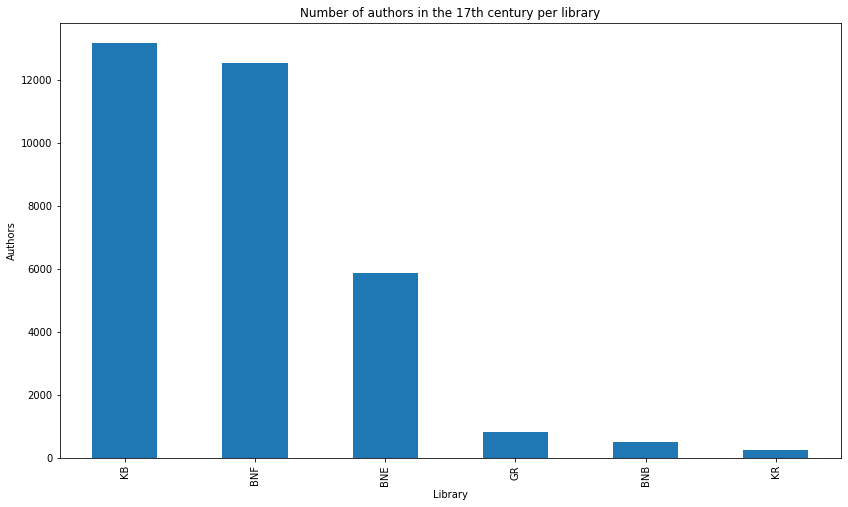

In [13]:
ax = libraries_df['org.value'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Number of authors in the 17th century per library")
ax.set_xlabel("Library")
ax.set_ylabel("Authors")
plt.show()

## Identifying the most common causes of death

In [ ]:
ax = libraries_df['deathcauseLabel.value'].value_counts().plot(kind='bar',
                                    figsize=(14,8),
                                    title="Causes of death of authors in the 17th century")
ax.set_xlabel("Cause of death")
ax.set_ylabel("Number of authors")
plt.show()

### Splitting occupation field

We create a new dataframe for the occupation information. The field is splited using the character '|'. Given an author, we will obtain a row per each occupation.

In [32]:
columns = ['item.value','occupationLabel.value']
occupation_df = pd.DataFrame(libraries_df, columns=columns)
occupation_df.head()

,item.value,occupationLabel.value
0,http://www.wikidata.org/entity/Q3766070,http://www.wikidata.org/entity/Q214917|http://...
1,http://www.wikidata.org/entity/Q1698179,http://www.wikidata.org/entity/Q4964182
2,http://www.wikidata.org/entity/Q8084303,http://www.wikidata.org/entity/Q36834|http://w...
3,http://www.wikidata.org/entity/Q98923992,
4,http://www.wikidata.org/entity/Q4194354,http://www.wikidata.org/entity/Q13365770|http:...


In [33]:
# Step 1
# We start with creating a new dataframe from the series with EmployeeId as the index
occupation_df = pd.DataFrame(libraries_df['occupationLabel.value'].str.split('|').tolist(), index=libraries_df['item.value']).stack()

# Step 2
# We now want to get rid of the secondary index
# To do this, we will make item.value as a column (it can't be an index since the values will be duplicated)
occupation_df = occupation_df.reset_index([0, 'item.value'])

# Step 3
# The final step is to set the column names as we want them
occupation_df.columns = ['item.value', 'occupationLabel.value']
occupation_df.head()

,item.value,occupationLabel.value
0,http://www.wikidata.org/entity/Q3766070,http://www.wikidata.org/entity/Q214917
1,http://www.wikidata.org/entity/Q3766070,http://www.wikidata.org/entity/Q49757
2,http://www.wikidata.org/entity/Q3766070,http://www.wikidata.org/entity/Q36180
3,http://www.wikidata.org/entity/Q1698179,http://www.wikidata.org/entity/Q4964182
4,http://www.wikidata.org/entity/Q8084303,http://www.wikidata.org/entity/Q36834


In [34]:
len(occupation_df)

67580

## Getting the most common occupations

Pandas provides many functionalities to group our data. For instance, the most common occupations are listed below.

In [35]:
occupation_df.groupby("occupationLabel.value")['item.value'].count().reset_index(name='count').sort_values(['count'], ascending=False).head(10)

,occupationLabel.value,count
613,http://www.wikidata.org/entity/Q36180,5237
0,,3707
4,http://www.wikidata.org/entity/Q1028181,3400
620,http://www.wikidata.org/entity/Q36834,2791
380,http://www.wikidata.org/entity/Q201788,2402
80,http://www.wikidata.org/entity/Q1234713,2331
701,http://www.wikidata.org/entity/Q49757,2324
857,http://www.wikidata.org/entity/Q82955,2260
233,http://www.wikidata.org/entity/Q1622272,2154
487,http://www.wikidata.org/entity/Q250867,1490


### Create a graph to identify patterns in occupation information

Each Wikidata link corresponds to a label as is shown below. We will analyse the most common occupations using a graph chart based on the Pyhon library NetworkX. It permits the use of a Pandas dataframe as a source.

KeyError: 'https://www.wikidata.org/wiki/Q36180'

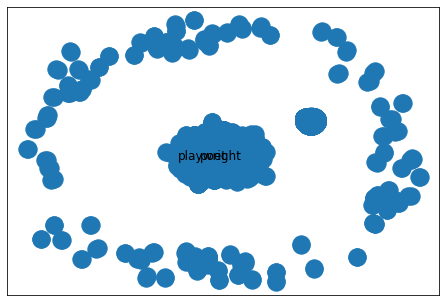

In [36]:
# Build your graph
G = nx.from_pandas_edgelist(occupation_df, 'item.value', 'occupationLabel.value')

labeldict = {}
labeldict["http://www.wikidata.org/entity/Q214917"] = "playwright"
labeldict["http://www.wikidata.org/entity/Q49757"] = "poet"
#labeldict["https://www.wikidata.org/wiki/Q36180"] = "writer"
labeldict["https://www.wikidata.org/wiki/Q1622272"] = "university teacher"
labeldict["http://www.wikidata.org/entity/Q36834"] = "composer"
labeldict["https://www.wikidata.org/wiki/Q1028181"] = "painter"
labeldict["https://www.wikidata.org/wiki/Q201788"] = "historian"
labeldict["http://www.wikidata.org/entity/Q1234713"] = "theologian"
labeldict["http://www.wikidata.org/entity/Q82955"] = "politician"

# Plot it
nx.draw(G, labels=labeldict, with_labels = True)

plt.show()

In addition, we can remove the labels to obtain a clean graph. The following NetworkX example is configured to work without labels.

In [ ]:
# Build your graph
G = nx.from_pandas_edgelist(occupation_df, 'item.value', 'occupationLabel.value')

# Plot it
nx.draw(G, with_labels = False)

plt.show()

## References
* https://rebeccabilbro.github.io/sparql-from-python/
* https://ipycytoscape.readthedocs.io/en/latest/
* https://nbviewer.jupyter.org/github/WillKoehrsen/Data-
* Analysis/blob/master/plotly/Plotly%20Whirlwind%20Introduction.ipynb
* https://medium.com/@sureshssarda/pandas-splitting-exploding-a-column-into-multiple-rows-b1b1d59ea12e
* https://towardsdatascience.com/from-dataframe-to-network-graph-bbb35c8ab675